In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.externals import joblib
from scipy.sparse import hstack
%matplotlib inline

In [2]:
df_news = pd.read_csv('../data/news_headlines.csv')
df_news.publish_date = pd.to_datetime(df_news.publish_date, format='%Y%m%d')
df_news['publish_year'] = df_news.publish_date.dt.year
df_news.sort_values('publish_date', inplace=True)
print('Rows: {}'.format(df_news.shape[0]))
df_news.head()

Rows: 1000001


,publish_date,headline_text,publish_year
23668,2003-02-19,surge in new car sales in aust abs,2003
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003
8208,2003-02-19,nsw opp defends claims of running race campaign,2003
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003
20646,2003-02-19,sterrey to steer sharks,2003


### Checking for duplicates in dataset

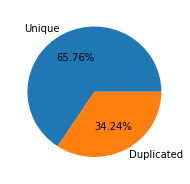

In [3]:
df_news.duplicated().map({True: 'Duplicated', False: 'Unique'}).value_counts().plot(
    kind='pie', autopct='%.2f%%', figsize=(3, 3), label='')

Example of duplicated

In [4]:
df_news.loc[df_news.headline_text == 'mans body found in river murray mannum']

,publish_date,headline_text,publish_year
968711,2017-07-03,mans body found in river murray mannum,2017
976437,2017-07-03,mans body found in river murray mannum,2017


In [5]:
df_news.drop_duplicates(inplace=True)

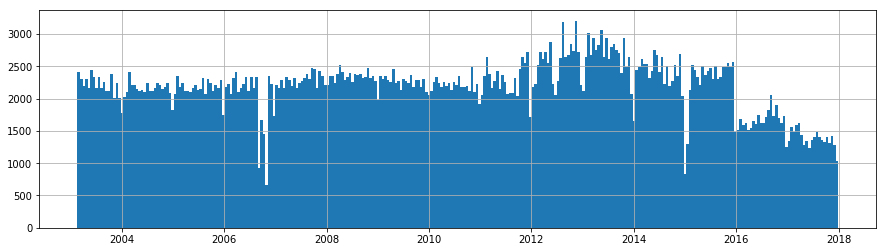

In [6]:
fig, ax = plt.subplots(figsize=(15,4))
df_news.publish_date.hist(ax=ax, bins=300);

# Pre processing text

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

def pre_processing(text):
    words = word_tokenize(text.lower(), language='english')
    words = [w for w in words if not w in stopwords]  # Remove stop words
    words = [w for w in words if not w in string.punctuation]  # Remove pontuacao
    words = [stemmer.stem(w) for w in words]  # Extrai radical da palavra
    return ' '.join(words)
def n_grams(text,n):
    words = word_tokenize(text.lower(), language='english')
    words = [words[i:i+n] for i in range(len(words)-n+1)]
    words = ['-'.join(words[i]) for i in range(len(words))]
    return ' '.join(words)
def char_ngrams(text,n):
    words = ''.join(text.lower().split())
    words = [words[i:i+n] for i in range(len(words)-n+1)]
    return ' '.join(words)



In [8]:
tic = time.time()

df_news['text'] = df_news.headline_text.apply(pre_processing)
df_news['2_grams'] = df_news.text.apply(lambda x: n_grams(x,2))
df_news['3_grams'] = df_news.text.apply(lambda x: n_grams(x,3))
df_news['4_chargrams'] = df_news.text.apply(lambda x: char_ngrams(x,4))

toc = time.time()
print('Elapsed time on text pre-processing: %d minutes and %d seconds.' % ((toc-tic)/60,(toc-tic)%60))
df_news.head()

Elapsed time on text pre-processing: 4 minutes and 23 seconds.


,publish_date,headline_text,publish_year,text,2_grams,3_grams,4_chargrams
23668,2003-02-19,surge in new car sales in aust abs,2003,surg new car sale aust ab,surg-new new-car car-sale sale-aust aust-ab,surg-new-car new-car-sale car-sale-aust sale-a...,surg urgn rgne gnew newc ewca wcar cars arsa r...
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003,new zealand impos visa entri zimbabw,new-zealand zealand-impos impos-visa visa-entr...,new-zealand-impos zealand-impos-visa impos-vis...,newz ewze wzea zeal eala alan land andi ndim d...
8208,2003-02-19,nsw opp defends claims of running race campaign,2003,nsw opp defend claim run race campaign,nsw-opp opp-defend defend-claim claim-run run-...,nsw-opp-defend opp-defend-claim defend-claim-r...,nswo swop wopp oppd ppde pdef defe efen fend e...
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003,qanta war plan cut 2500 job outrag union,qanta-war war-plan plan-cut cut-2500 2500-job ...,qanta-war-plan war-plan-cut plan-cut-2500 cut-...,qant anta ntaw tawa awar warp arpl rpla plan l...
20646,2003-02-19,sterrey to steer sharks,2003,sterrey steer shark,sterrey-steer steer-shark,sterrey-steer-shark,ster terr erre rrey reys eyst yste stee teer e...


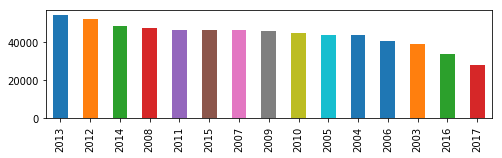

In [9]:
df_news.publish_year.value_counts().plot(kind='bar', figsize=(8, 2))

In [10]:
df_news.to_pickle('df_news.pkl')

# Feature extraction

### Using entire dataset:

In [11]:
from sklearn.externals import joblib

df_news = joblib.load('df_news.pkl')

In [12]:
df_news = df_news.reset_index().drop('index', axis=1)

In [13]:
sentences = df_news.headline_text.map(lambda x: x.split())

In [14]:
from gensim.models import Word2Vec

model = Word2Vec(sentences, min_count=50,size=300,workers=4)

In [15]:
def invocab(sentence):
    x = []
    for i in range(len(sentence)):
        if(sentence[i] in model.wv.vocab.keys()):
            x.append(sentence[i])
    return x

In [16]:
texts = sentences.map(lambda x: invocab(x))

In [17]:
features = np.zeros((texts.shape[0],300))
for i,text in enumerate(texts):
    if len(text) != 0:
        feats = model.wv[text].sum(axis=0)
        features[i] = feats
    else:
        feats = np.zeros((300,))
        features[i] = feats

In [18]:
from sklearn.preprocessing import normalize

features = normalize(features)

In [19]:
joblib.dump(features,'features_.pkl')

['features_.pkl']

# Clustering:

In [160]:
features = joblib.load('features_.pkl')

In [21]:
def validity(model, N):
    intra = (model.inertia_ / N)
    centers = model.cluster_centers_
    flag = 1e10
    for i in range(centers.shape[0]):
        for j in range(i+1, centers.shape[0]):
            distance = paired_distances(centers[i].reshape(-1,1),centers[j].reshape(-1,1)).sum()
            if distance<flag:
                flag=distance
    inter = flag
    return intra/inter

### Estimating number of clusters:

In [ ]:
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_distances
use_cache = True

inertias, scores, sils, val = [], [], [], []
n_clusters = range(2,31,1)
N = features.shape[0]
for n_cluster in n_clusters:
    tic = time.time()
    cluster_path = os.path.join('KMeans', 'KMeans_w2v_headline{}.pkl'.format(n_cluster))
    if not use_cache or not os.path.exists(cluster_path):
        cluster = KMeans(n_cluster, random_state=42, max_iter = 300, n_jobs=-1)
        cluster.fit(features)
        joblib.dump(cluster, cluster_path)
    else:
        cluster = joblib.load(cluster_path)
    inertias.append(cluster.inertia_)
    scores.append(cluster.score(features))  
    sils.append(silhouette_score(features, cluster.labels_, random_state=42, sample_size=5000))
    val.append(validity(cluster,N))
    print('Number of clusters: %d' % n_cluster)
    toc = time.time()
    print('Elapsed time: %d hours, %d minutes and %d seconds' % ((toc-tic)/3600,((toc-tic)/60)%60,(toc-tic)%60))


In [23]:
import numpy as np

def plot(name, data, line_func=None):
    fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(12, 5))
    ax.plot(n_clusters, data)
    if line_func:
        ax.axvline(n_clusters[line_func(data)], color='gray', alpha=0.3)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel(name)
    ax.set_title('Elbow method')

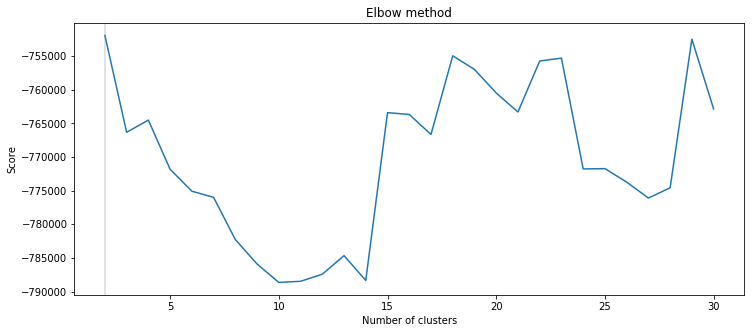

In [24]:
plot('Score', scores, np.argmax)

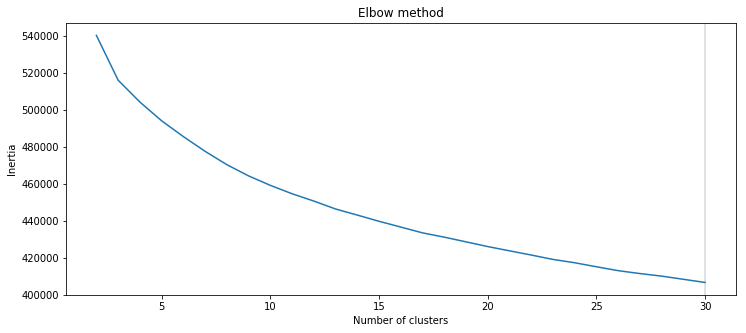

In [25]:
plot('Inertia', inertias, np.argmin)

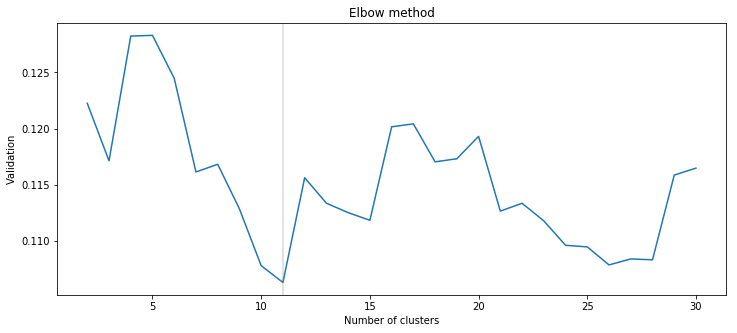

In [26]:
plot('Validation', val, np.argmin)

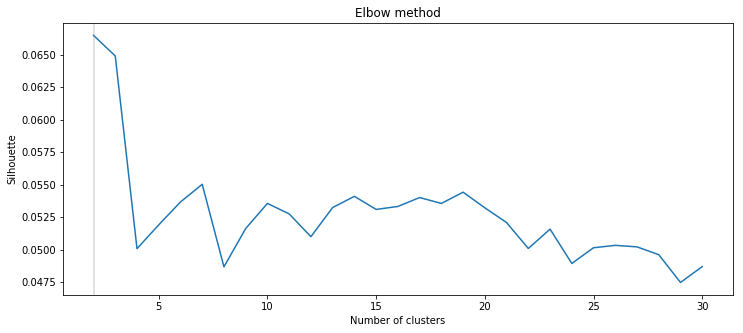

In [27]:
plot('Silhouette', sils, np.argmax)

In [28]:
print('Ideal number of clusters, based on validation ratio: {}'.format(np.argmin(val)+2))

Ideal number of clusters, based on validation ratio: 11


# Definition of label names

In [100]:
from sklearn.feature_extraction.text import CountVectorizer

def most_frequent(texts, n=10):
        counts = CountVectorizer(max_features=n, token_pattern=r'\w+-*\w+-*\w+')
        counts.fit_transform(texts)
        return [key for key in counts.vocabulary_]

In [161]:
cluster_path = "KMeans/KMeans_w2v_headline11.pkl"
cluster = joblib.load(cluster_path)
features = joblib.load('features_.pkl')

In [164]:
df_news['cluster'] = cluster.predict(features)

#### Cluster 0:

In [166]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==0], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==0], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==0], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==0].head(10))

Top 10 words:
['man', 'jail', 'charg', 'murder', 'court', 'polic', 'death', 'face', 'accus', 'drug']


Top 10 2-grams:
['polic-probe', 'court-told', 'plead-guilti', 'face-court', 'front-court', 'man-charg', 'man-jail', 'child-sex', 'polic-investig', 'man-face']


Top 10 3-grams:
['man-face-court', 'man-found-guilti', 'man-front-court', 'man-plead-guilti', 'child-sex-abus', 'polic-search-miss', 'front-court-accus', 'child-sex-charg', 'child-sex-offenc', 'man-charg-murder']


10 examples of headines:
5                 refshauge wins defamation court case
8                 teen to face court over drug charges
21         kelly disgusted at alleged bp ethanol scare
27          police defend aboriginal tent embassy raid
78     german court to give verdict on sept 11 accused
82               police cracking down on driver safety
86               irish man arrested over omagh bombing
95                       snowtown murder trial delayed
103            jury to consider verdict in murder case
1

A label for this cluster group is: X

#### Cluster 1:

In [167]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==1], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==1], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==1], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==1].head(10))

Top 10 words:
['plan', 'call', 'help', 'set', 'new', 'council', 'get', 'govt', 'fund', 'urg']


Top 10 2-grams:
['urg-help', 'public-urg', 'farmer-urg', 'council-urg', 'mental-health', 'broken-hill', 'govt-urg', 'resid-urg', 'gold-coast', 'climat-chang']


Top 10 3-grams:
['fed-govt-urg', 'public-get-say', 'govt-urg-help', 'qld-govt-urg', 'vic-govt-urg', 'public-urg-help', 'move-closer-realiti', 'work-set-start', 'feder-govt-urg', 'govt-urg-boost']


10 examples of headines:
4                               sterrey to steer sharks
7                more women urged to become councillors
9      unions to ask members to support public protests
24             meeting to consider tick clearance costs
26             bushfire victims urged to see centrelink
30    expressions of interest sought to build livestock
34               community urged to help homeless youth
37      patterson defends decision not to attend health
41         onesteel to invest 80m in whyalla steelworks
43        martin

A label for this cluster group is: <b>X</b>

#### Cluster 2:

In [168]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==2], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==2], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==2], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==2].head(10))

Top 10 words:
['final', 'cup', 'australia', 'take', 'world', 'win', 'aussi', 'day', 'open', 'lead']


Top 10 2-grams:
['test-day', 'australian-open', 'south-africa', 'capit-hill', 'sri-lanka', 'new-zealand', 'grand-final', 'world-cup', 'us-open', 'one-day']


Top 10 3-grams:
['capit-hill-monday', 'test-day-one', 'live-stream-updat', 'tour-de-franc', 'test-day-two', 'one-plus-one', 'ash-test-day', 'rugbi-world-cup', 'capit-hill-wednesday', 'nrl-live-stream']


10 examples of headines:
14    aussie qualifier stosur wastes four memphis match
28               blizzard buries united states in bills
29                   reading go third in first division
32      calleri avenges final defeat to eliminate massu
38      williams says tight bowling key to warriors win
42             pienaar shines as ajax frustrate arsenal
47               osullivan in world cross country doubt
48                    webb favourite for ladies masters
59               carews freak goal leaves roma in ruins
74     

A label for this cluster group is: <b>X</b>

#### Cluster 3:

In [169]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==3], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==3], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==3], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==3].head(10))

Top 10 words:
['korea', 'leader', 'elect', 'say', 'talk', 'china', 'protest', 'iraq', 'new', 'australia']


Top 10 2-grams:
['asylum-seeker', 'human-right', 'n-korea', 'islam-state', 'sri-lanka', 'donald-trump', 'hong-kong', 'north-korea', 'al-qaeda', 'e-timor']


Top 10 3-grams:
['kim-jong-un', 'papua-new-guinea', 'south-china-sea', 'san-suu-kyi', 'middl-east-peac', 'asylum-seeker-boat', 'anti-war-protest', 'free-trade-deal', 'anti-terror-law', 'un-secur-council']


10 examples of headines:
1           new zealand imposes visa entry for zimbabwe
18     talk of asian nuclear arms race unhelpful downer
22      saudi arabia tells arabs war on iraq inevitable
23          nth koreans seek asylum at japanese embassy
61         aust addresses un security council over iraq
64             dems hold plebiscite over iraqi conflict
117            mugabe to touch down in paris for summit
121          us british aircraft attack sth iraq target
127      brigadier dismisses reports troops harassed in

A label for this cluster group is: <b>X</b>

#### Cluster 4:

In [170]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==4], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==4], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==4], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==4].head(10))

Top 10 words:
['interview', 'die', 'michael', 'media', 'call', 'john', 'talk', 'speak', 'abc', 'david']


Top 10 2-grams:
['abc-sport', 'interview-john', 'interview-michael', 'extend-interview', 'interview-david', 'abc-news', 'nrl-interview', 'media-call', 'ntch-podcast', 'abc-entertain']


Top 10 3-grams:
['interview-john-cartwright', 'abc-news-breakfast', 'interview-des-hasler', 'interview-neil-henri', 'abc-entertain-news', 'steven-schubert-speak', 'belinda-varischetti-interview', 'nation-press-club', 'interview-ivan-cleari', 'speak-pacif-beat']


10 examples of headines:
222               distance swimmer maroney calls it quits
259                                maroney calls it quits
319     jackson hits back at explosive british tv inte...
390          costello unhappy he wasnt consulted by stone
740                michael jackson sues documentary maker
919           former whyalla director praises crash compo
1293    former mayor speaks out over mismanagement rep...
1335        l

A label for this cluster group is: <b>X</b>

#### Cluster 5:

In [171]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==5], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==5], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==5], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==5].head(10))

Top 10 words:
['qld', 'coast', 'new', 'fire', 'countri', 'warn', 'nsw', 'hour', 'weather', 'flood']


Top 10 2-grams:
['hour-podcast', 'nsw-countri', 'south-east', 'tas-countri', 'countri-hour', 'abc-weather', 'north-coast', 'gold-coast', 'rural-qld', 'wa-countri']


Top 10 3-grams:
['qld-countri-hour', 'nsw-countri-hour', 'rural-qld-podcast', 'vic-countri-hour', 'countri-hour-podcast', 'nt-countri-hour', 'mid-north-coast', 'tas-countri-hour', 'sa-countri-hour', 'wa-countri-hour']


10 examples of headines:
6              worksafe probes potato harvester injuries
31            radioactive spill at wmcs olympic dam mine
54                       rain eases wheatbelt water woes
58          griffiths under fire over project knock back
75           massive drug crop discovered in western nsw
91                       rabbit control program on trial
120    more water restrictions predicted for northern...
138                       drought taking toll on insects
147               gippsland fir

A label for this cluster group is: <b>X</b>

#### Cluster 6:

In [172]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==6], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==6], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==6], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==6].head(10))

Top 10 words:
['plan', 'call', 'chang', 'say', 'govern', 'new', 'council', 'govt', 'fund', 'health']


Top 10 2-grams:
['job-cut', 'royal-commiss', 'mental-health', 'climat-chang', 'pulp-mill', 'age-care', 'wind-farm', 'nsw-govt', 'health-servic', 'council-consid']


Top 10 3-grams:
['mental-health-servic', 'public-get-say', 'nuclear-wast-dump', 'local-govt-group', 'premier-colin-barnett', 'wind-farm-plan', 'council-green-light', 'coal-seam-gas', 'murray-darl-basin', 'get-green-light']


10 examples of headines:
2      nsw opp defends claims of running race campaign
3     qantas war plan to cut 2500 jobs outrages unions
11                          bathhouse plans move ahead
13               shire offers assurances over finances
17      rfs rejects claim that act authorities spurned
25     nsw govt under fire for holding back vegetation
36                  nsw opp pledges 50m drought relief
39                  low demand forces air service cuts
40                         nursing student

A label for this cluster group is: <b>X</b>

#### Cluster 7:

In [173]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==7], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==7], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==7], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==7].head(10))

Top 10 words:
['plan', 'hope', 'call', 'set', 'new', 'get', 'boost', 'support', 'fund', 'push']


Top 10 2-grams:
['heritag-list', 'prompt-call', 'nation-rural', 'spark-call', 'green-light', 'mental-health', 'broken-hill', 'gold-coast', 'fund-boost', 'rural-news']


Top 10 3-grams:
['rural-news-thursday', 'rural-news-friday', 'rural-news-tuesday', 'rural-news-monday', 'get-go-ahead', 'rural-news-wednesday', 'death-prompt-call', 'get-green-light', 'nation-rural-news', 'death-spark-call']


10 examples of headines:
15                 record amount for gladstone ventures
16      peace agreement may bring respite for venezuela
20                  orientation begins for uni students
50    iraqs neighbours plead for continued un inspec...
51                            plan for second skatepark
53       no side effects for new whooping cough vaccine
66                      funds announced for bridge work
68      vff to buy stock feed pellets for fire affected
85                         warne 

A label for this cluster group is: <b>X</b>

#### Cluster 8:

In [174]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==8], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==8], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==8], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==8].head(10))

Top 10 words:
['rate', 'price', 'profit', 'market', 'rise', 'job', 'mine', 'farmer', 'busi', 'share']


Top 10 2-grams:
['iron-ore', 'share-market', 'interest-rate', 'abc-busi', 'rate-rise', 'news-market', 'nation-rural', 'market-analysi', 'busi-news', 'rural-news']


Top 10 3-grams:
['busi-news-market', 'interest-rate-rise', 'share-market-close', 'australian-share-market', 'news-market-analysi', 'multi-million-dollar', 'abc-busi-news', 'nation-rural-news', 'iron-ore-price', 'half-year-profit']


10 examples of headines:
0                     surge in new car sales in aust abs
73               heavy metal deposits survey nearing end
81          commonwealth bank cuts fixed home loan rates
112    hacker gains access to eight million credit cards
129                 wine chief bounces back from sacking
135                   lend leases posts 370 million loss
149                       rain boosts farmers confidence
152                              oil prices hit new high
181              

A label for this cluster group is: <b>X</b>

#### Cluster 9:

In [175]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==9], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==9], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==9], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==9].head(10))

Top 10 words:
['year', 'report', 'say', 'show', 'drum', 'make', 'new', 'australia', 'get', 'australian']


Top 10 2-grams:
['rural-report', 'drum-friday', 'climat-chang', 'drum-thursday', 'drum-wednesday', 'drum-tuesday', 'social-media', 'drum-monday', 'donald-trump', 'australian-year']


Top 10 3-grams:
['qld-rural-report', 'rural-nsw-rural', 'great-barrier-reef', 'sa-rural-report', 'one-plus-one', 'australia', 'premier-mike-rann', 'rural-qld-rural', 'good-behaviour-bond', 'nsw-rural-report']


10 examples of headines:
12                 stop changing the rules fans tell afl
45          oh brother your times up says ganguly senior
46         more than 40 pc of young men drink alcohol at
90                    still no sign of missing fisherman
143                      war talk takes toll on all ords
189    christmas is detention centre no go claims qua...
224                  beware the standard alcoholic drink
274                         bedi labels murali a chucker
293               

A label for this cluster group is: <b>X</b>

#### Cluster 10:

In [176]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==10], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==10], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==10], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==10].head(10))

Top 10 words:
['man', 'miss', 'dead', 'woman', 'found', 'polic', 'car', 'crash', 'kill', 'die']


Top 10 2-grams:
['woman-die', 'hous-fire', 'man-kill', 'man-die', 'death-toll', 'plane-crash', 'found-dead', 'search-miss', 'bodi-found', 'car-crash']


Top 10 3-grams:
['suicid-bomber-kill', 'man-bodi-found', 'man-found-dead', 'light-plane-crash', 'fatal-car-crash', 'search-continu-miss', 'us-soldier-kill', 'death-toll-rise', 'die-car-crash', 'car-bomb-kill']


10 examples of headines:
10             six palestinians killed in gaza incursion
19                 girl injured in head on highway crash
33         man arrested after central qld hijack attempt
35       search continues for victims in s korean subway
65                 four injured in head on highway crash
89      death toll continues to climb in s korean subway
99     investigations underway into death toll of korean
108                dog mauls 18 month old toddler in nsw
122                      probe launched into plane crash

A label for this cluster group is: <b>X</b>